# Exploratory Inference of LDA in Pyro 

 # Why do we care?
 We're interested in exploring probabilistic programming as it
 applies to LDA and its variants.  LDA describes an extremely
 intuitive generative process, and because of this it enjoys
 continued research into its expansions. It is also both flexible
 and interpretable.  Since everybody here knows what LDA is, we
 won't go over the details.

 But, inference is really, really hard.  Most expansions to LDA that
 get published require subtle tricks to even get inference working.

 Examples are:
   1. Supervised LDA for classification only works for real-valued supervision;
      (Blei & McAuliffe, 2008)
   2. Multiple Classification LDA was published a full year later; it required a
      subtle application of Jensen's inequality to reduce O(K^N) time to O(K^2)
      (Wang et al., 2009)
   3. Hierarchical Supervised LDA (Perotte, 2011) can't model a true 
      is-a-this-and-not-that hierarchical relationship
 Just about every incremental idea requires some special trick, no matter how
 logical the idea is.

__In spite of how understandable and flexible LDA__ is, even statisticians and
practitioners will have a tough time deploying criticizable models for their needs.

Fortunately, using Pyro to overcome intractable integrals was day 2; so let's get started
with LDA in Pyro!

In [15]:
import sys
sys.path.append("../..")
from pres import *

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danyanghe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 # Dataset and Course of Research
 We study almost 300,000 wine reviews from WineEnthusiast.com.  This dataset is
 richly tagged, with numerical scores from 0 to 100, hierarchical region information
 (country->region->winery) and variety.
 Reviews are short but basically already bags of words; we don't anticipate many words
 being wasted on nuanced semantics or stop words, so we believe that these reviews may
 be long enough for LDA to work.
 
 > "Damp earth, black plum and dank forest herbs show
 > on the nose of this single-vineyard expression. The palate offers
 > cranberry and raspberry as well as savory soy and dried beef flavors,
 > all with earthy herbs in the background."

As such, we expect to see a progression of topic modelling capabilities as we march
down our list of models:
 - LDA,
 - LDA + classification v. supervised LDA,
 - Hierarchical LDA + classification v. supervised LDA
 - Hierarchical supervised LDA v. supervised LDA
 - Spectral Methods for supervised LDA v. supervised LDA

Dataset fetched.


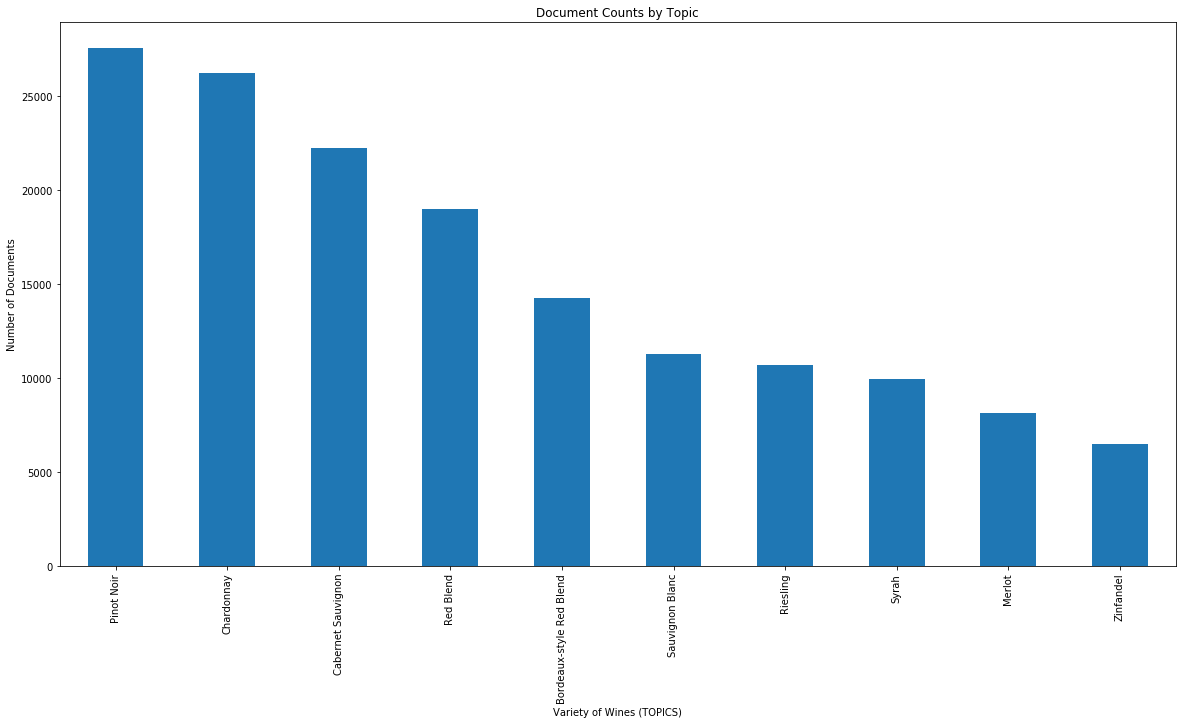

In [4]:
plot_filtered_variety_wine()

Dataset fetched.
Preprocessing tokens...
Building Index and ngram...
Preprocessing + Indexing complete.


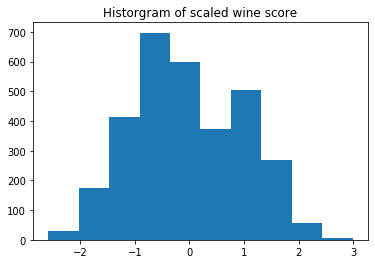

In [5]:
plot_regression_response_distribution()

# Vanilla LDA
__Top Words Per Topic (10 topics)__
<img src="https://ibb.co/89m12pm">

We see substantial overlap across topics, suggesting our inference doesn't work. Perhaps our data is truly just a very poor fit for LDA; this was always a risk. So we tried to come up with a customised stop word list to remove words that show up in almost every review, like wine, tannin, and fruit. Then, we did different parameter initialization to tune the hyperparameters. We found random initialization to document dirichlet parameter and uniform initialization to topic dirichlet parameter yields better result. 

__LDA graphical model & mean field inference model__
<img src="files/lda_plate_notation.png"> ![](files/lda_plate_notation.png)
To tweak the $model$ and $guide$, we compared the result for two different implementations of guide. 
1. Implement the exact same procedure as the mean field variational inference as shown in the figure above. 
2. Enumerate out the topic assignment discrete random variable $z$.


But, the same topic words overlap still exists.

__losses for different model runs__
<img src="files/losses.png"> ![](files/losses.png)
__number of unique words in topics as training goes__
<img src="files/unique_words.png"> ![](files/unique_words.png)
__topic-word distribution__
<img src="files/beta.png"> ![](files/beta.png)



# Topic Assignment Visualization

In [16]:
plot_pyro_lda_1_theta_tsne()

Loading BokehJS ...

# Amortised inference for LDA

In [13]:
    import pyLDAvis as vis
    import pickle
    import numpy as np
    run = "lda_vae_3000_200_10_l_SGD_0.01"
    with open(f"files/{run}/vocab{run}.pkl", "rb") as f:
        vocab = pickle.load(f)
    with open(f"files/{run}/num_words_per_txt_{run}.pkl", "rb") as f:
        doc_lengths = pickle.load(f)
    with open(f"files/{run}/vocab_count_{run}.pkl", "rb") as f:
        vocab_count = pickle.load(f)
    lamb = np.load(f"files/{run}/topic_term_1000_lda_vae_3000_200_10_l_SGD_0.01.npy")
    gamma = np.load(f"files/{run}/doc_topics_1000_lda_vae_3000_200_10_l_SGD_0.01.npy")
    data = {'topic_term_dists': lamb,
            'doc_topic_dists': gamma,
            'vocab': list(vocab.keys()),
             'term_frequency':list(vocab_count.values()),
           'doc_lengths':doc_lengths}
    wine_vis_data = vis.prepare(**data)
    vis.display(wine_vis_data)

/Users/danyanghe/anaconda3/envs/mlpp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [10]:
with open(f"files/{run}/posterior_lda_vae_3000_200_10_l_SGD_0.01.pkl", "rb") as f:
    posterior = pickle.load(f)
for i in range(len(posterior)):
    posterior[i] = posterior[i].item()
with open(f"files/{run}/likelihood_lda_vae_3000_200_10_l_SGD_0.01.pkl", "rb") as f:
    likelihood = pickle.load(f)
for i in range(len(posterior)):
    likelihood[i] = likelihood[i].item()

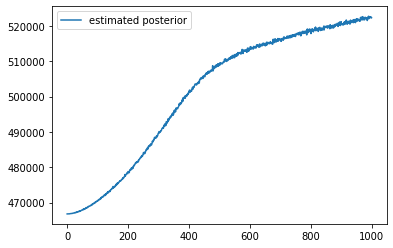

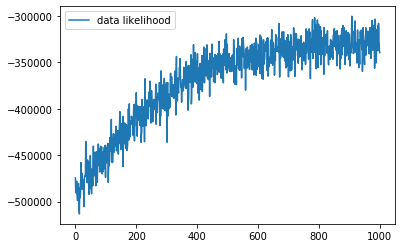

In [12]:
import matplotlib.pyplot as plt
plt.plot(posterior)
plt.legend(["estimated posterior"])
plt.show()
plt.plot(likelihood)
plt.legend(["data likelihood"])
plt.show()

# Supervised LDA?

If the objective of LDA may itself not offer enough rewards to separate out topics, an extra loss may help; we can use sLDA to potentially learn more latent structure.

Supervised LDA (sLDA) is a variant of LDA by adding an additional gaussian regression on topic assignment latent variable z and using the average topic assignments of words in a review to predict the score of the review.

__sLDA graphical model__
<img src="https://ibb.co/X4PgjGX"> 
Thus, in inference, to estimate the $\eta$ and $\sigma$, we put normal prior on them and let Pyro to derive an approximate posterior.

__sLDA training loss__
<img src="files/training_loss_sda.png"> ![](files/training_loss_sda.png)


# sLDA's top words per topic
<img src="files/words_per_topic_slda.png"> ![](files/words_per_topic_slda.png)

We still see word overlap showing up. At this point, we have an inkling that our data simply won't permit factorizing via LDA. But, convinced by the richness of the dataset and the natural topic-variety mapping in our heads, we remain undeterred.  Rather, we conclude that we can check our work by fitting the same topic model via CAVI, using code widely available on the internet (from blei-lab).


# Lasso Regression Baseline on Words

Dataset fetched.
Preprocessing tokens...
Building Index and ngram...
Preprocessing + Indexing complete.
alpha selected: 0.0017840634683358697
lasso regression train score: 0.6574270513914282
lasso regression test score: 0.5091732294296113
mse: 0.5030211190980896


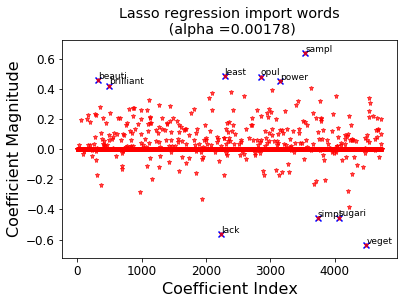

<Figure size 432x288 with 0 Axes>

In [3]:
plot_regression_features()

# sLDA regression result based on topics

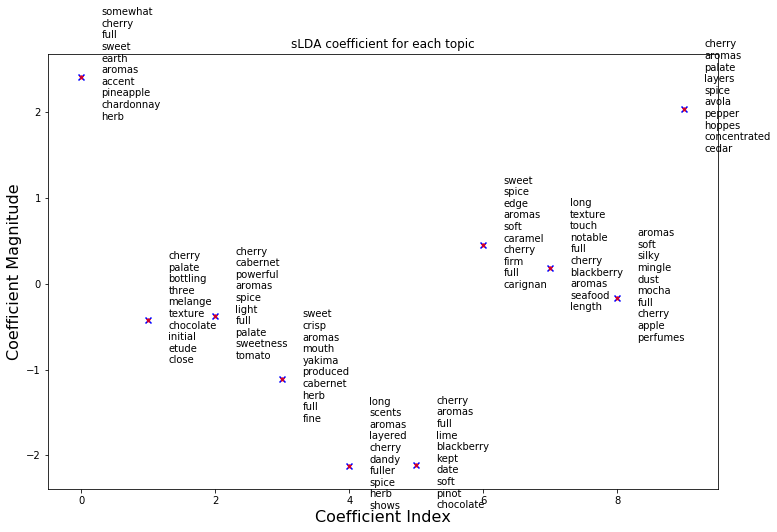

In [2]:
plot_slda_regression_topic_words()

# Posterior Collapse

We suspect that what we're experiencing is a collapse in all of our estimated distributions to the same point.  This could be MAP or another local optimum, and the literature seems vaguely aware that this can happen for topic models:

>"...despite some notable successes ...,black box inference methods are significantly more challenging to apply to topic models. For example, in initial experiments, we tried to apply ADVI (Kucukelbir et al., 2016), ..., but it was difficult to obtain any meaningful topics. Two main challenges are: first, the Dirichlet prior ... hinders reparameterisation, and second, the well known problem of component collapsing (Dinh & Dumoulin, 2016), in which the inference network becomes stuck in a bad local optimum in which all topics are identical" (Srivastava and Sutton, 2017)

However, most references to the phenomenon are in relation to VAEs, where it is also referred to as KL or mode collapse.  The cause is not well understood (Lucas et al., 2019), but the accepted definition is that it occurs when the distribution of latent variable $z$ given variational parameter $\theta$ is fit such that $q(z \vert \theta) = p(z)$; samples of the latent variable become independent of the variational parameters.

We hope that by scrutinizing each parameter update from Pyro and CAVI, we can get a sense of what's going on.  We can either trace parameters in Pyro (which is difficult to do because of how many parameters there are for LDA), or we can hand-derive the parameter updates it uses.  Pyro employs BBVI for discrete distributions; it will furthermore use context clues from plates to Rao-Blackwellize where possible, so for the remainder of this discussion we will work with the analytical updates we believe Pyro is running.

# Parameter Updates

Recall the parameter updates from CAVI:

\begin{align}
\phi_{d,n}^k &\propto [E[\log \theta_{dk}] - E[\log \beta_{k,w_{d,n}}]] \\
\gamma_d &= \alpha + \sum_{n=1}^N \phi_{dn}^k \\
\lambda_k &= \eta + \sum_{d=1}^D \sum_{n=1}^N \phi_{dn}^k w_{dn}
\end{align}


Versus the same updates for BBVI:
\begin{align}
&\gamma \leftarrow \gamma + \rho\nabla_\gamma L(\gamma); \qquad \phi_{d,n} \leftarrow \phi_{d,n} + \rho\nabla_{\phi_{d,n}} L; \\
&\nabla_\gamma L = E_{q(\theta_d \vert \gamma)}\left[\nabla_\gamma \log q(\theta_d \vert \gamma) \left( \log p (\theta_d \vert \alpha) - \log q(\theta_d \vert \gamma) + E_{q(z_d \vert \phi_d)}[\log p(z_d \vert \theta_d)] \right) \right] \\
&\nabla_{\phi_{d,n}} L \\
&\:\:\:= E_{q(z_{d,n} \vert \phi_{d,n})}[\nabla_{\phi_{d,n}} \log q(z_{d,n} \vert \phi_{d,n}) \\
&\qquad\times \left( \log p (w_{d,n} \vert z_{d,n}, \beta) - \log q (z_{d,n} \vert \phi_{d,n}) + E_{q(\theta_d \vert \gamma)}[\log p(z_{d,n} \vert \theta_d)] \right) ] \\
\end{align}


In practice, we estimate these expectations Via Monte-Carlo, which we can write down (over $B$ samples)
\begin{align}
\nabla&_\gamma L(\gamma) \approx \frac{1}{B} \sum_{d=1}^B \left(\log \theta_d - \Psi(\gamma) + \Psi\left(\sum_{i=1}^K \gamma _i\right)\right) \\
& \qquad\times \left(\log(Dir(\theta_d \vert \alpha))-\log(Dir(\theta_d \vert \gamma)) + \frac{1}{N_d} \sum_{n=1}^{N_d} \log \theta_{d}^T \bar{z}_{d,n} \right)
\end{align}

\begin{align}
\nabla&_{\phi_d,n} L(\phi_{d, n}) \approx \frac{1}{N_d}\sum_{n=1}^{N_d} \frac{1}{\phi_{d,n,z_{d,n}}} \left(\log \beta_{z_{d,n},w_{d,n}} - \log \phi_{d,n,z_{d,n}} + \frac{1}{B} \sum_{d=1}^B \log \theta_d^T z_{d,n} \right)
\end{align}

A few things to note:
 - Updates aren't comparable; CAVI is run until convergence while BBVI will step iteratively (along with other parameters).  But the similarities are evident
 - All updates show some tradeoff between updating a parameter and shrinking toward its prior. $\theta$ isn't the prior of $\phi$, but they are closely related via the model.
 - Both BBVI updates have Monte-Carlo estimates that can be written as KL divergences

How so?

\begin{align}
\nabla_\gamma L(\gamma) = E_{q(\theta_d \vert \gamma)}\left[\nabla_\gamma \log q(\theta_d \vert \gamma) \left( \log p (\theta_d \vert \alpha) - \log q(\theta_d \vert \gamma) + \underbrace{E_{q(z_d \vert \phi_d)}[\log p(z_d \vert \theta_d)]}_{-KL(q(z_d \vert \phi_d)||p(z_d \vert \theta_d))} \right) \right]
\end{align}

\begin{align}
\nabla_{\phi_{d,n}} L &(\phi_{d,n})\\
& = E_{q(z_{d,n} \vert \phi_{d,n})}\left[\nabla_{\phi_{d,n}} \log q(z_{d,n} \vert \phi_{d,n}) \left( \log p (w_{d,n} \vert z_{d,n}, \beta) - \log q (z_{d,n} \vert \phi_{d,n}) + \underbrace{E_{q(\theta_d \vert \gamma)}[\log p(z_{d,n} \vert \theta_d)]}_{+\log p(z_{d,n}) - KL(q(\theta_d \vert \gamma)||p(\theta_d \vert z_{d, n})) + KL(q(\theta_d \vert \gamma) || p(\theta_d))} \right) \right] \\
\end{align}



See the second expectation by writing $p(z_{d,n}\vert\theta_d) = p(\theta_d\vert z_{d,n}) p(z_{d,n}) / p(\theta_d)$.
 - The second KL divergence can be ignored, because $\theta_d$ and $\gamma$ aren't in the Markov blanket of $\phi_{d,n}$
 - $\log(p(z_{d,n}) / q(z_{d,n} \vert \phi_{d,n}))$ should trigger some alarm bells.  This term will guide our variational distribution towards the unconditional $p(z)$: the hallmark of posterior collapse.  If these variational parameters are guided towards a collapsed maximum, the iterative gradient updates will drag all model parameters towards the collapse.
 
__We believe that noisy gradients in BBVI__ induce posterior collapse.  In the MC expressions for the expectations, you can see that __unlike with CAVI, at each iteration other variational parameters will only update the current one through dot products and KL divergences__.  If the projections of a parameter on the others is small, all model linkages break down, and we experience a collapse.  Evidently, even Rao-Blackwellized estimation is too noisy for the sheer number of parameters we have.


# CAVI for LDA

__cavi topic word result__
<img src="files/words_per_topic_cavi.png"> ![](files/words_per_topic_cavi.png)

# Conclusions

### Summary

We explored LDA and its variant sLDA in Pyro and attempted inference on real world wine review text data. To dive deeper into why Pyro is not working, we tested our inference versus CAVI and analyzed the gradient updates in BBVI. We concluded that BBVI fails because of noisy update in the simultaneous update of topic-word distributions and document-topic distributions. 

Models variation: LDA (with different versions of inference algorithms), sLDA

Inference techniques: Variational Inference (CAVI and BBVI)

Implementation strategies: Pyro

### Challenges

1. Getting Pyro-implemented LDA inference to work. We tried different implementation tricks, stop words removal and hypyterparameter tuning.
2. Analyzing why Pyro fails in this BBVI procedure. We hand derived BBVI for Pyro and observe step by step how parameters are updated.

### Future Work

Identifying the problem in BBVI informs our next steps.  Options are:

1. Change subsampling; in experiments, we need very large batch sizes, (whereas batch VI succeeds with small batches) (no good)
2. Consider models without $\phi$.  No worrying about tractability, so look to collapsed models. (no good)
3. Try friendlier priors.


 # References
 - (Blei & McAuliffe, 2008) https://papers.nips.cc/paper/3328-supervised-topic-models.pdf
 - (Wang et al., 2009) http://vision.stanford.edu/pdf/WangBleiFei-Fei_CVPR2009.pdf
 - (Schroeder, 2018) https://edoc.hu-berlin.de/bitstream/handle/18452/19516/thesis_schroeder_ken.pdf?sequence=3
 - (Perotte et al., 2011) https://papers.nips.cc/paper/4313-hierarchically-supervised-latent-dirichlet-allocation
 - (Thoutt, 2017) https://www.kaggle.com/zynicide/wine-reviews
 - (Srivastava and Sutton, 2017) https://arxiv.org/pdf/1703.01488.pdf
 - (Lucas et al., 2019) https://openreview.net/pdf?id=r1xaVLUYuE